In [14]:
%load_ext autoreload
%autoreload 2


%matplotlib inline
%cd C:\MAD4AG

from tqdm.auto import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
import geopandas as gpd
import shapely
from shapely.geometry import LineString, Point


warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\MAD4AG


In [83]:
day ='4'

file = r'.\dbs\twins\03-21-schedule-%s.pkl'%day

df_act_schedule_0 = pd.read_pickle(file)



In [84]:
# pick an agent by the sequence

#individual_uid= df_act_schedule_0['uid'][df_act_schedule_0.act_seq_simp_0==('Home', 'Work', 'Other', 'Home')].iloc[50]
individual_uid= df_act_schedule_0['uid'][df_act_schedule_0['act_seq_simp_'+day]==('Home', 'Other','Work','Other','Other', 'Home')].iloc[28]



individual = df_act_schedule_0[(df_act_schedule_0['uid']==individual_uid)]

individual['purpose'][ ~individual['purpose'].isin(['Home', 'Work'])] = individual['purpose'][ ~individual['purpose'].isin(['Home', 'Work'])].str[:5]

In [85]:
individual['dur'] = individual['h_e']- individual['h_s']
individual['dur'] = individual['dur'] / 60
individual['dur'] = individual['dur'].round(2)

individual['h_s'] = individual['h_s']/60
individual['h_s'] = individual['h_s'].round(1)


In [86]:
color_dict = {
    'Home': 'tab:green',
    'Work': 'tab:blue',
    'Other': 'tab:orange'
}

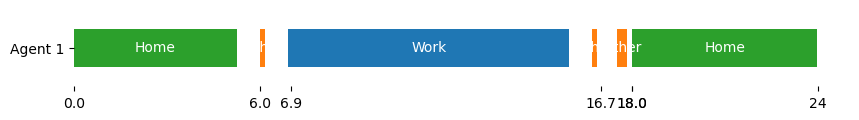

In [87]:
# Declaring a figure "gnt"
fig, ax = plt.subplots(figsize=(10, 1))

# Setting Y-axis limits
ax.set_xlim(0, 25)
ax.set_ylim(-2, 2)
#sns.scatterplot(df_tst, y='PId', x='time', ax=ax)
ax.broken_barh(list(zip(individual.h_s, individual.dur)), (-1, 2),
               facecolors =[color_dict[x] for x in individual.purpose])
for x1, x2, act in individual[['h_s', 'dur', 'purpose']].values:
    ax.text(x=x1 + x2/2,
            y=0,
            s=act,
            ha='center',
            va='center',
            color='white',
            )
ax.set_xticks([np.round(x) for x in individual.h_s] + [24],
              labels=[x for x in individual.h_s] + [24])
ax.set_yticks([0], labels=[f'Agent {1}'])
plt.box(on=None)
plt.show()

In [88]:
individual_trip = individual
individual_trip['lat_dest'] =individual_trip['lat'].shift(1)
individual_trip['lng_dest'] =individual_trip['lng'].shift(1)
individual_trip = individual_trip.iloc[1:]


In [89]:

individual_trip['from'] = individual_trip.apply(lambda row: Point([row['lat'], row['lng']]), axis=1)
individual_trip['to'] = individual_trip.apply(lambda row: Point([row['lat_dest'], row['lng_dest']]), axis=1)

individual_trip['geometry'] = individual_trip.apply(lambda row: LineString([row['from'], row['to']]), axis=1) #Create a linestring column


In [90]:
gdf_events_ind = gpd.GeoDataFrame(individual_trip, geometry='geometry')
gdf_events_ind.crs ="epsg:4326"

gdf_events_ind['points'] = gdf_events_ind.apply(lambda x: [y for y in x['geometry'].coords], axis=1)


In [91]:
points = []
for x in gdf_events_ind['points'].values:
    points += x
gdf_points = gpd.GeoDataFrame({}, geometry=[shapely.geometry.Point(x[0], x[1]) for x in points])
center = gdf_points.dissolve().centroid
center = [center.x.values[0], center.y.values[0]]

In [92]:
gdf_plans_ind = gpd.GeoDataFrame(individual,geometry=gpd.points_from_xy(individual.lng, individual.lat), crs="EPSG:4326")

In [93]:
color_dict = {
'Home': 'green',
'Work': 'blue',
'Other': 'orange'}

icon_dict = {
'Home': 'home',
'Work': 'briefcase',
'Other': 'shopping-cart'}

In [94]:
m = folium.Map(location=center, zoom_start=10)


gdf_plans_ind.apply(lambda row : folium.CircleMarker(
    location=(row["lat"], row["lng"]), radius=5,
    fill_color=color_dict[row['purpose']],
    popup=row['purpose'],
    color=color_dict[row['purpose']],
    fill_opacity=0.4,opacity=0.6).add_to(m), axis=1)

gdf_events_ind.apply(lambda row : folium.PolyLine(locations=row["points"],
                                                  color='gray',
                                                  opacity=0.8,
                                                  popup = 'trip '+str(row['act_seq'])
                                                  ).add_to(m), axis=1)

gdf_events_ind.apply(lambda row : folium.Marker(
    location=(row['geometry'].centroid.x+0.003,row['geometry'].centroid.y+0.003),
    icon=folium.DivIcon(html=f"""<div style="font-family: Arial; font-size: 12px;">trip_{str(row['act_seq'])}</div>"""),
    opacity=0.8).add_to(m), axis=1)

gdf_plans_ind.apply(lambda row : folium.Marker(
    location=(row["lat"], row["lng"]),
    icon=folium.Icon( icon=icon_dict[row['purpose']], color=color_dict[str(row['purpose'])], prefix='fa'),
    popup=row['purpose'],
    opacity=0.8).add_to(m), axis=1)

folium.map.CustomPane("labels").add_to(m)

m